In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f = open('finitefault.txt')
lines = f.readlines()
lines[106] = lines[106].replace('Hypo','')
data = [[ float(s) for s in line.split()] for line in lines[27:]]

In [3]:
import pandas as pd
df = pd.DataFrame(data, columns = 'lat lon z rake slip ontime'.split())
df = df.rename(columns={'z':'depth'})
df['depth'] = 1000*df['depth']
df['strike'] = 15
df['dip'] = 18
df['L'] = 40000
df['W'] = 40000
df['reference'] = 'center'
df['slip'] /= 100
df['lon'] +=360
df.head()

,lat,lon,depth,rake,slip,ontime,strike,dip,L,W,reference
0,-39.001,287.862,81082.0,111.0,0.43,142.5,15,18,40000,40000,center
1,-38.652,287.977,81082.0,102.0,0.91,122.3,15,18,40000,40000,center
2,-38.304,288.092,81082.0,112.1,0.03,106.2,15,18,40000,40000,center
3,-37.956,288.206,81082.0,111.9,0.03,92.1,15,18,40000,40000,center
4,-37.608,288.321,81082.0,114.0,1.14,79.0,15,18,40000,40000,center


In [4]:
df = df['lat lon depth slip strike dip rake L W reference'.split()]

In [5]:
df.to_csv('earthquake.csv',index=False)

# Easywave format

In [6]:
df.head()

,lat,lon,depth,slip,strike,dip,rake,L,W,reference
0,-39.001,287.862,81082.0,0.43,15,18,111.0,40000,40000,center
1,-38.652,287.977,81082.0,0.91,15,18,102.0,40000,40000,center
2,-38.304,288.092,81082.0,0.03,15,18,112.1,40000,40000,center
3,-37.956,288.206,81082.0,0.03,15,18,111.9,40000,40000,center
4,-37.608,288.321,81082.0,1.14,15,18,114.0,40000,40000,center


In [8]:
df_easywave = df.copy()
df_easywave['reference']='C'
df_easywave['depth'] /=1000
df_easywave['L'] /=1000
df_easywave['W'] /=1000

In [9]:
df_easywave.head()

,lat,lon,depth,slip,strike,dip,rake,L,W,reference
0,-39.001,287.862,81.082,0.43,15,18,111.0,40.0,40.0,C
1,-38.652,287.977,81.082,0.91,15,18,102.0,40.0,40.0,C
2,-38.304,288.092,81.082,0.03,15,18,112.1,40.0,40.0,C
3,-37.956,288.206,81.082,0.03,15,18,111.9,40.0,40.0,C
4,-37.608,288.321,81.082,1.14,15,18,114.0,40.0,40.0,C


In [10]:
f = open('fault.flt','w')

for index, row in df_easywave.iterrows():
    rowString = '-location {lon} {lat} {depth} -refpos {reference} -strike {strike} -dip {dip} -rake {rake} -slip {slip} -size {L} {W}\n'
    rowString = rowString.format(**row)
    f.write(rowString)

f.close()

# Geoclaw

In [11]:
from clawpack.geoclaw import dtopotools

In [12]:
df_geoclaw = df.copy()

In [13]:
fault = dtopotools.Fault()
fault.subfaults = []
for index, fault_row in df_geoclaw.iterrows():
    subfault = dtopotools.SubFault()
    subfault.strike = fault_row["strike"]
    subfault.length = fault_row["L"]
    subfault.width = fault_row["W"]
    subfault.depth = fault_row["depth"]
    subfault.slip = fault_row["slip"]
    subfault.rake = fault_row["rake"]
    subfault.dip = fault_row["dip"]
    subfault.longitude = fault_row["lon"]
    subfault.latitude = fault_row["lat"]
    subfault.coordinate_specification = "centroid"
    fault.subfaults.append(subfault)

In [14]:
x = np.linspace(-77, -67, 100) + 360
y = np.linspace(-40, -30, 100)
times = [1.]
x.min(), x.max()

(283.0, 293.0)

In [15]:
fault.create_dtopography(x,y,times)
dtopo = fault.dtopo
dtopo_fname = "earthquake.tt3"
dtopo.write(dtopo_fname, dtopo_type=3)

In [16]:
dtopo_read = dtopotools.DTopography()
dtopo.read(dtopo_fname, dtopo_type=3)

In [17]:
x = dtopo.x
y = dtopo.y

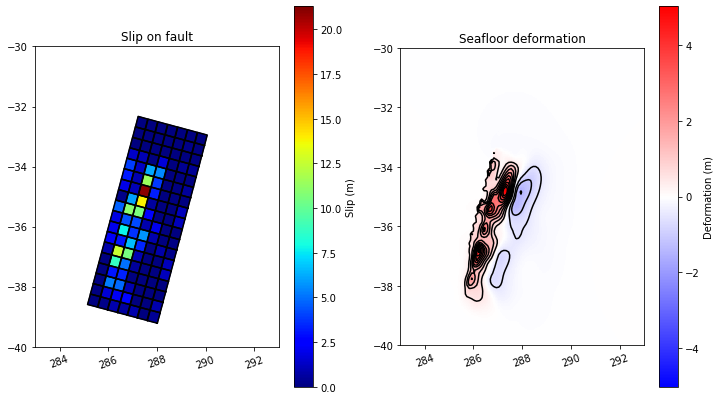

In [18]:
plt.figure(figsize=(12,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fault.plot_subfaults(axes=ax1,slip_color=True)
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(y.min(),y.max())
dtopo.plot_dZ_colors(t=1.,axes=ax2)